# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from agentlace.action import ActionServer, ActionConfig, ActionClient
import tensorflow as tf
import numpy as np
import utils
import matplotlib.pyplot as plt
import time
import os

import imageio

2024-10-25 15:34:28.837635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 15:34:28.852344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 15:34:28.856595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 15:34:28.868212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 15:34:29.545661: W tensorflow/compiler/tf2

# New Data Format
MP4s + .npzs! trajectories of even size... 

In [2]:
# stitch together a WHOLE folder of trajectories ... is that possible...

In [3]:
base_dir = f"/home/lydia/data/frodobot/supervised"
traj_dir = f"{base_dir}/fri25-20-24-9am"
all_files = os.listdir(traj_dir)
all_files = sorted(all_files)

npzs = [f for f in all_files if f[-4:] == ".npz"]
images = {
    "front": [f for f in all_files if f[-5:] == "t.mp4"],
    "rear": [f for f in all_files if f[-5:] == "r.mp4"],
    "map": [f for f in all_files if f[-5:] == "p.mp4"],
}

In [4]:
# process NPZs
arrays = []
for npz in npzs:
    data = np.load(os.path.join(traj_dir, npz))
    arrays.append(data["obs_array"])

concat_arr = np.concatenate(arrays, axis = 0)
print(f"have {concat_arr.size} data points with data type {concat_arr.dtype}")

have 7639 data points with data type [('timestamp_img', '<f4'), ('timestamp_data', '<f4'), ('battery', '<i4'), ('signal_level', '<i4'), ('orientation', '<i4'), ('lamp', '<i4'), ('speed', '<f4'), ('gps_signal', '<f4'), ('latitude', '<f4'), ('longitude', '<f4'), ('vibration', '<f4'), ('accels', '<f4', (6, 4)), ('gyros', '<f4', (5, 4)), ('mags', '<f4', (1, 4)), ('rpms', '<f4', (5, 5)), ('last_action_linear', '<f4', (3,)), ('last_action_angular', '<f4', (3,))]


In [5]:
# process movie frames

# takes about a second per 200 frame video... 
def get_video_frames(video_path):
    frames = []
    reader = imageio.get_reader(video_path)
    total_frames = reader.count_frames()
    for frame in reader:
        frames.append(np.array(frame))
    reader.close()
    return np.array(frames)

video_file = images["front"][0]
ans = get_video_frames(os.path.join(traj_dir, video_file))

In [6]:
# 60 seconds for 39 200 frame videos ...
front_frames_all = [get_video_frames(os.path.join(traj_dir, vid)) for vid in images["front"]]

In [8]:
front_frames_all[0].shape

(200, 576, 1024, 3)

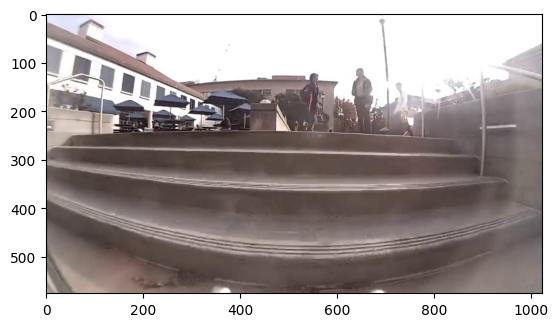

In [17]:
plt.imshow(front_frames_all[35][158])

In [9]:
front_frames_all[0]

array([[[[118, 117, 148],
         [118, 117, 148],
         [117, 116, 147],
         ...,
         [ 99,  93, 100],
         [ 90,  84,  91],
         [ 86,  80,  87]],

        [[110, 109, 140],
         [110, 109, 140],
         [111, 110, 141],
         ...,
         [ 88,  82,  89],
         [ 90,  84,  91],
         [ 92,  86,  93]],

        [[110, 109, 140],
         [110, 109, 140],
         [111, 110, 141],
         ...,
         [ 88,  82,  89],
         [ 91,  85,  92],
         [ 92,  86,  93]],

        ...,

        [[ 47,  56,  95],
         [ 47,  56,  95],
         [ 48,  57,  96],
         ...,
         [ 45,  45,  53],
         [ 44,  44,  52],
         [ 44,  44,  52]],

        [[ 47,  56,  95],
         [ 47,  56,  95],
         [ 48,  57,  96],
         ...,
         [ 41,  41,  49],
         [ 43,  43,  51],
         [ 44,  44,  52]],

        [[ 54,  63, 102],
         [ 54,  63, 102],
         [ 53,  62, 101],
         ...,
         [ 34,  34,  42],
        

In [8]:
len(front_frames_all)

39

In [9]:
front_frames_all = np.concatenate(front_frames_all, axis = 0)

: 

In [ ]:
front_frames_all.shape

In [21]:
ans.shape

(200, 576, 1024, 3)

In [21]:
# load and concatenate npzs...


In [7]:
concat_arr[0]

(1.7298985e+09, 1.7298733e+09, 100, 5, 85, -1826644856, 0., 38.25, 37.874126, -122.265686, 0.21, [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.]], [[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]], [0.01568604, 0.        , 0.        ], [ 0.,  0., -0.])

In [3]:
hi = np.load("/home/lydia/data/frodobot/supervised/0.0.31/1729571465_0_observations.npz")

In [4]:
hi["obs_array"]

array([(1.7295715e+09, 1.7295462e+09, 68, 5, 217, -1827677048, 0., 34.5 , 37.87341, -122.2672 , 0.28, [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.]], [[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]], [-0.00784302,  0.        ,  0.        ], [ 0.,  0., -0.]),
       (1.7295715e+09, 1.7295462e+09, 64, 5, 216, -1827677048, 0., 34.25, 37.87341, -122.26719, 0.3 , [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]], [[0., 0., 0., 0.]], [[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]], [-0.00784302,  0.        ,  0.        ], [ 0.,  0., -0.]),
       (1.

# Robot Action Server

In [9]:
action_client = ActionClient(
            server_ip="localhost",
            config=utils.make_action_config("frodobot")
        )

DEBUG:root:Req-rep client is connecting to localhost:1111


In [6]:
for i in range(3):
    action_client.act("action_vw", np.array([0, -0.3]))
    time.sleep(0.2)

DEBUG:root:WARNING: No res from server. reset socket.


In [10]:
for i in range(20):
    
    action_client.act("action_vw", np.array([0.2, -0.3]))
    time.sleep(0.2)

In [11]:
recent_obs = action_client.obs()

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/lydia/anaconda3/envs/frodobots/lib/python3.11/site-packages/matplotlib

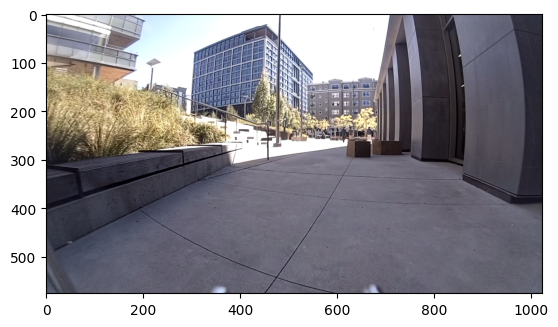

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 8192


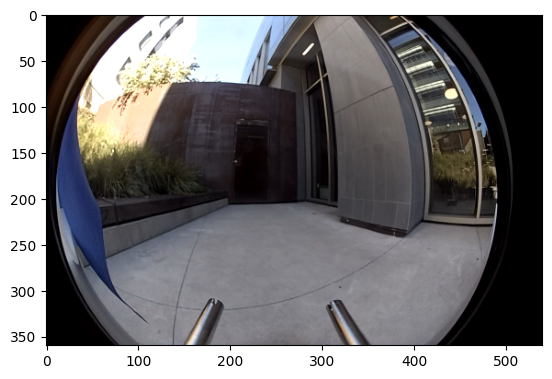

In [12]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)
plt.show()
back_frame = utils.decode_from_base64(recent_obs["rear_frame"])
plt.imshow(back_frame)
plt.show()

In [ ]:
front_frame = utils.decode_from_base64(recent_obs["front_frame"])
plt.imshow(front_frame)

# Data Collection

In [2]:
import tensorflow_datasets as tfds
import dlimp
from dlimp.dataset import DLataset
import matplotlib.pyplot as plt
import utils

In [6]:
dataset_dir = "/home/lydia/data/frodobot/"
dataset_name = "supervised:0.0.19"

dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)
dataset = (
    DLataset.from_rlds(dataset_builder)
    # .filter(lambda traj: traj["_len"][0] >= 4)
).ignore_errors(log_warning=True, name=f"ignore_errors")

dataset_iter = dataset.iterator()

In [4]:
total_len = 0
i = 0

for step in dataset_iter:
    i += 1
    total_len += len(step["observation"]["speed"])

print(i)

5


2024-10-21 12:54:12.056894: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message corrupted record at 1865375163
2024-10-21 12:54:12.057134: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Input dataset was expected to contain 34 elements but contained only 5 elements.
2024-10-21 12:54:12.066922: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
one_step = next(dataset_iter)

In [9]:
step["observation"].keys()

dict_keys(['speed', 'rear_frame', 'rpms', 'last_action_linear', 'timestamp_data', 'longitude', 'vibration', 'accels', 'lamp', 'signal_level', 'timestamp_img', 'last_action_angular', 'gyros', 'battery', 'latitude', 'map_frame', 'mags', 'front_frame', 'orientation', 'gps_signal'])

In [14]:
step["observation"]["timestamp_data"][0]

1729530400.0

In [16]:
from datetime import datetime

local_time = datetime.fromtimestamp(int(step["observation"]["timestamp_data"][0]))

In [17]:
local_time

datetime.datetime(2024, 10, 21, 10, 6, 8)

In [13]:
step["observation"]["timestamp_data"] - step["observation"]["timestamp_img"]

array([-25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -25216., -25216., -25216., -25216., -25216., -25216.,
       -25216., -252

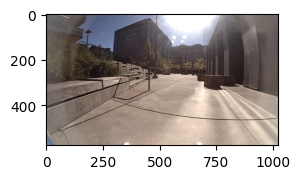

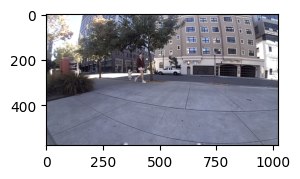

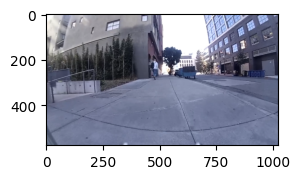

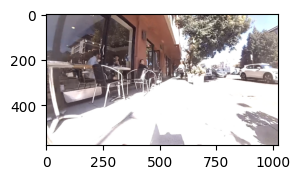

2024-10-21 12:53:04.123897: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message corrupted record at 1865375163
2024-10-21 12:53:04.123952: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Input dataset was expected to contain 34 elements but contained only 5 elements.


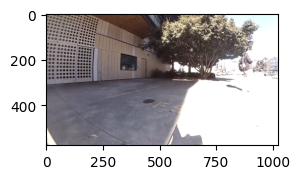

In [25]:
step_num  = 0
for step in dataset_iter:
    step_len = len(step["observation"]["speed"])
    
    plt.figure(figsize=(3, 2))
    plt.imshow(utils.decode_from_base64(step["observation"]["front_frame"][i]))
    plt.show()

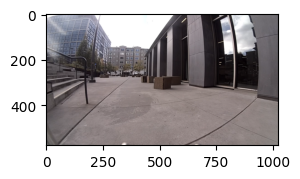

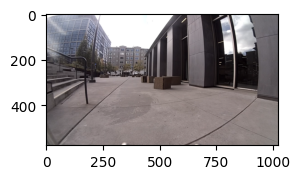

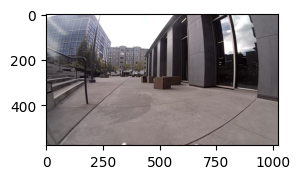

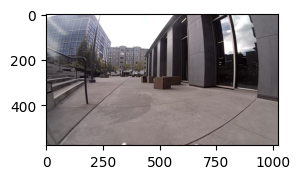

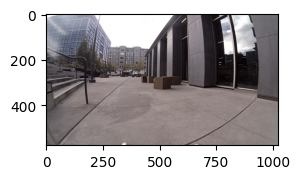

In [8]:
for i in range(5):
    plt.figure(figsize=(3, 2))
    plt.imshow(utils.decode_from_base64(one_step["observation"]["front_frame"][i]))
    plt.show()

# Map

In [8]:
import folium
from IPython.display import display

# Coordinates for a location (latitude, longitude)
latitude = one_step["observation"]["latitude"][0]
longitude = one_step["observation"]["latitude"][0]

# Create a map centered around the coordinates
my_map = folium.Map(location=[latitude, longitude], zoom_start=12)

step_num  = 0
for step in dataset_iter:
    step_len = len(step["observation"]["speed"])
    
    for i in range(min(5, step_len - 1)):
        lat, long = step["observation"]["latitude"][i], step["observation"]["longitude"][i], 
        folium.Marker([lat, long], popup=f"{i} {step_num}").add_to(my_map)

    step_num += 1

# Display the map in the notebook
my_map

2024-10-21 12:54:23.808942: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message corrupted record at 1865375163
2024-10-21 12:54:23.808986: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Input dataset was expected to contain 34 elements but contained only 5 elements.
